# Convolutional Beta-Variational AutoEncoder

### This notebook contains a Tensorflow Keras-based Convolutional Variational Auto-Encoder (using mixture of sub-classing and functional api) trained on [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import seaborn as sns; sns.set()

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# verify gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 441825762950780924
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6762114908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3273421593053516086
physical_device_desc: "device: 0, name: GeForce GTX 980M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [4]:
###### Constants ######
BATCH_SIZE=256
MAX_EPOCHS=5
PERCENT_VAL=0.2 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 128
INPUT_SHAPE = (28, 28, 1)
BETA = 1.2

# Save/Load Model Constants
SAVE_PATH = os.path.join('..', 'models', 'cvae')

LOADING_WEIGHTS = True
SAVING_WEIGHTS = False
TRAINING = False

In [5]:
###### Function Definitions ######
def normalize(images, labels=None):
    # Add channel
    images = tf.expand_dims(images, -1)
    images = tf.cast(images, tf.float32)
    images /= 255
    
    return images, images

def display_image(image):
    image = image if type(image) is np.ndarray else image.numpy()
    image = image.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def display_images(images, rows, cols, dpi=128, wspace=0, hspace=0, labels=None):
    fig = plt.figure(dpi=dpi)

    spec = gs.GridSpec(rows, cols)
    spec.update(wspace=wspace, hspace=hspace)

    i = 0
    for image in images:
        image = image if type(image) is np.ndarray else image.numpy()
        image = image.reshape(image.shape[:-1]) # remove channel
        ax = plt.subplot(spec[i])
        
        if labels:
            plt.title(labels[i])
            
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.show()
    
    return fig
    
def split_data(data, labels, percent):
    n = data.shape[0]
    indices = np.random.permutation(n)
    
    split = int(np.ceil(n * percent))
    
    test_ndxs = indices[split:]
    val_ndxs = indices[:split]
    
    return data[test_ndxs], labels[test_ndxs], data[val_ndxs], labels[val_ndxs]

def plot_history(history, metrics, figsize=(15,10)):
    plt.figure(figsize=figsize)

    for i, metrics in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        for metric in metrics:
            plt.plot(range(len(history.epoch)), history.history[metric], label=metric)
        plt.legend(loc='upper right')        

In [6]:
# 2nd elements are labels, which we don't need
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()

xtest, ytest, xval, yval = split_data(xtest, ytest, PERCENT_VAL)

n_training = xtrain.shape[0]
n_test = xtest.shape[0]
n_val = xval.shape[0]

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain)).map(normalize).cache().shuffle(n_training//10).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).repeat()
val_ds = tf.data.Dataset.from_tensor_slices((xval, xval)).map(normalize).cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest)).map(normalize).cache().batch(BATCH_SIZE)

## Visualizing a Few Exemplars from the **TEST** Data Set

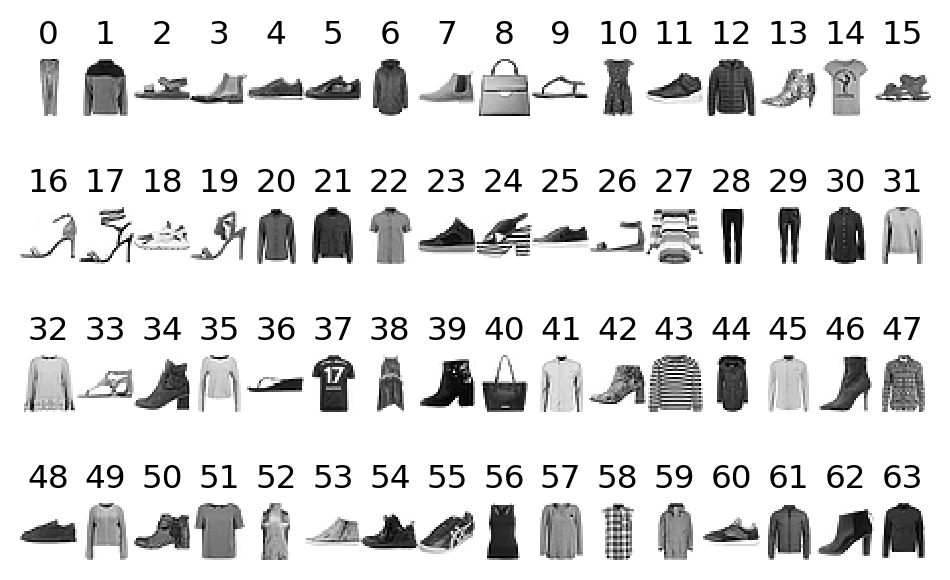

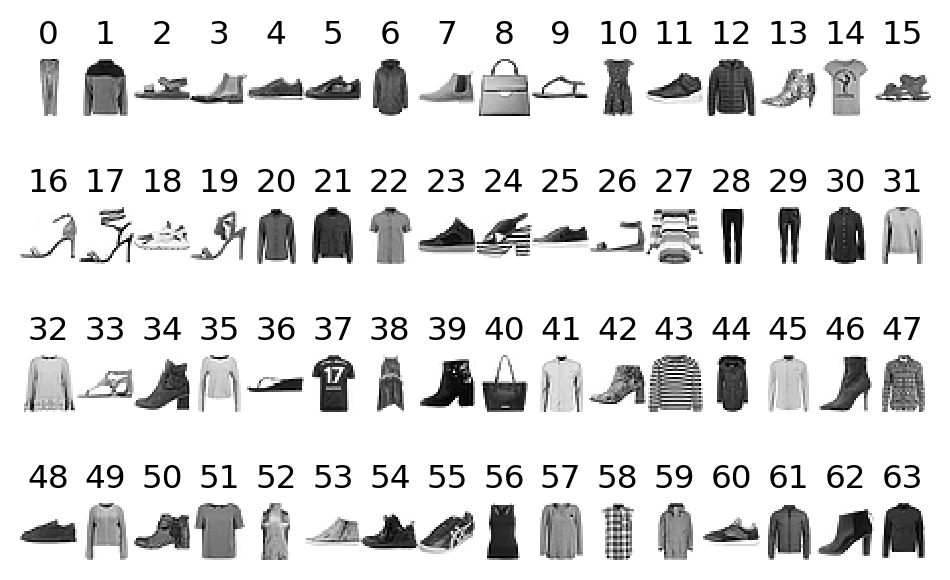

In [8]:
images, _ = next(iter(test_ds))
display_images(images[0:64], rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

# Defining the Keras Model (Using Sub-Classing)

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        # layers
        self.conv1 = tf.keras.layers.Conv2D(
          filters=64, 
          kernel_size=2, 
          strides=(1, 1), 
          padding='same', 
          activation='relu', 
          name='encoder/conv1')
        self.maxpool1 = tf.keras.layers.MaxPool2D(name='encoder/maxpool1')
        self.conv2 = tf.keras.layers.Conv2D(
          filters=32, 
          kernel_size=3, 
          strides=(1, 1), 
          padding='same', 
          activation='relu', 
          name='encoder/conv2')
        self.maxpool2 = tf.keras.layers.MaxPool2D(name='encoder/maxpool2')
        self.conv3 = tf.keras.layers.Conv2D(
          filters=32, 
          kernel_size=4, 
          strides=(1, 1), 
          padding='same', 
          activation='relu', 
          name='encoder/conv3')
        self.maxpool3 = tf.keras.layers.MaxPool2D(name='encoder/maxpool3')
        self.flatten = tf.keras.layers.Flatten(name='encoder/flatten')        
        self.logvar = tf.keras.layers.Dense(latent_dim, name='encoder/logvar')
        self.mu = tf.keras.layers.Dense(latent_dim, name='encoder/mu')
        self.sigma = tf.keras.layers.Lambda(lambda t: tf.keras.backend.exp(.5*t), name='encoder/sigma')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)   
        return self.mu(x), self.logvar(x), self.sigma(self.logvar(x))


In [10]:
class Sampler(tf.keras.layers.Layer):
    def __init__(self):
        super(Sampler, self).__init__()
        
    def call(self, inputs):
        mu, sigma = inputs
        
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        
        # Gaussian noise
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return mu + sigma * epsilon

In [11]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(Decoder, self).__init__(*args, **kwargs)
        
        # layers
        self.dense1 = tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu, name='decoder/dense1')
        self.reshape1 = tf.keras.layers.Reshape(target_shape=(7, 7, 64), name='decoder/reshape1')
        self.trans_conv1 = tf.keras.layers.Conv2DTranspose(
          filters=64,
          kernel_size=3,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv1')
        self.trans_conv2 = tf.keras.layers.Conv2DTranspose(
          filters=32,
          kernel_size=3,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv2')
        self.trans_conv3 = tf.keras.layers.Conv2DTranspose(
          filters=1, 
          kernel_size=3, 
          strides=(1, 1),
          activation='sigmoid',
          padding='same', 
          name='decoder/deconv3')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape1(x)
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        return self.trans_conv3(x)

# VAE Loss Function
<h2>
$
\begin{align}
\DeclareMathOperator{\ExpectedVal}{\mathbf{E}}
\DeclareMathOperator{\log}{\operatorname{log}}
\mathcal{L}(\theta, \phi; \mathbf{x}^{(i)}) = -D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z})) + \ExpectedVal_{q_\phi(\mathbf{z}\vert\mathbf{x^{(i)}})}\big[\log p_\theta(\mathbf{x}^{(i)}\vert \mathbf{z})\big],
\end{align}
$ 
<br><br>
where $D_{KL}$ is the KL-divergence.
<br><br><br><br>
If we assume that $p_\theta(\mathbf{z}) = \mathcal{N}(0, 1) \text{ and } q_\phi(\mathbf{z}\vert \mathbf{x}^{(i)})$ is Gaussian, then the KL-divergence can be integrated analytically and has the value
$    
\begin{align}
\DeclareMathOperator{\log}{\operatorname{log}}
D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z}) = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2),
\end{align}
$
<br>
where $J$ is the dimensionality of the latent vector $z$.
</h2>

In [12]:
encoder = Encoder(latent_dim=LATENT_DIM)
sampler = Sampler()
decoder = Decoder()

x = tf.keras.layers.Input(shape=INPUT_SHAPE)
mu, logvar, sigma = encoder(x)
z = sampler((mu, sigma))
x_recon = decoder(z) 

# Custom loss layer for reconstruction
class ReconstructionLoss(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super().__init__(**kwargs)

    def call(self, inputs):
        x = inputs[0]
        x_recon = inputs[1]
        
        recon_loss = tf.keras.backend.sum(tf.keras.backend.binary_crossentropy(x, x_recon), axis=(1,2))
        recon_loss = tf.keras.backend.mean(recon_loss)
        
        self.add_loss(recon_loss, inputs=inputs)
        
        return recon_loss

# Custom loss layer for kl-loss
class KLLoss(tf.keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        self.is_placeholder = True
        super().__init__(**kwargs)
        
        self.beta = beta

    def call(self, inputs):
        mu = inputs[0]
        logvar = inputs[1]
        
        # KL Divergence for Gaussian Distributions (see Kingma and Welling, 2014, p.11)
        # --> Assumes that the prior p(Z) is normal and the posterior approximation q(z|x) is Gaussian
        kl_loss = -0.5 * self.beta * tf.keras.backend.sum(
            1.0 + logvar - tf.keras.backend.square(mu) - tf.keras.backend.exp(logvar), axis=-1)
        kl_loss = tf.keras.backend.mean(kl_loss)
        
        self.add_loss(kl_loss, inputs=inputs)
        
        return kl_loss

recon_loss = ReconstructionLoss(name='ReconLoss')([x, x_recon])
kl_loss = KLLoss(name='KL', beta=BETA)([mu, logvar])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = tf.keras.Model(inputs = x, outputs = [x_recon, recon_loss, kl_loss])
model.compile(optimizer=optimizer, loss=None)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Encoder)               ((None, 128), (None, 109184      input_1[0][0]                    
__________________________________________________________________________________________________
sampler (Sampler)               (None, 128)          0           encoder[0][0]                    
                                                                 encoder[0][2]                    
__________________________________________________________________________________________________
decoder (Decoder)               (None, 28, 28, 1)    460225      sampler[0][0]                

In [14]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Visualize Reconstruction of Sampled Images *PRIOR TO TRAINING*.

### note: if not loading weights then this should look like random noise

In [15]:
# visualize generation before training
if TRAINING:
    images, _ = next(iter(test_ds))

    xs, _, _ = model(images)  # reconstructed images

    display_images(images=xs[0:64], rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

## Train The Model and Display Metrics For Model Performance on **Training** and **Validation** Data Sets

In [16]:
tf.autograph.set_verbosity(10)
if TRAINING:
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(train_ds, 
                        callbacks=[early_stop_callback],
                        epochs=MAX_EPOCHS, 
                        steps_per_epoch=np.ceil(n_training/BATCH_SIZE), 
                        validation_data=val_ds, 
                        validation_steps=np.ceil(n_val/BATCH_SIZE))
    
    plot_history(history, metrics=[('loss', 'val_loss')])

In [17]:
if SAVING_WEIGHTS:
    try:
        model.save_weights(SAVE_PATH, save_format='tf')
    except Exception as e:
        print(e)
        
elif LOADING_WEIGHTS:
    try:
        model.load_weights(SAVE_PATH)
    except Exception as e:
        print(e)

## Visualize Reconstruction of Sampled Images *AFTER TRAINING*.

### note: these are images from the **TEST** data set: the auto-encoder was NOT trained on these!

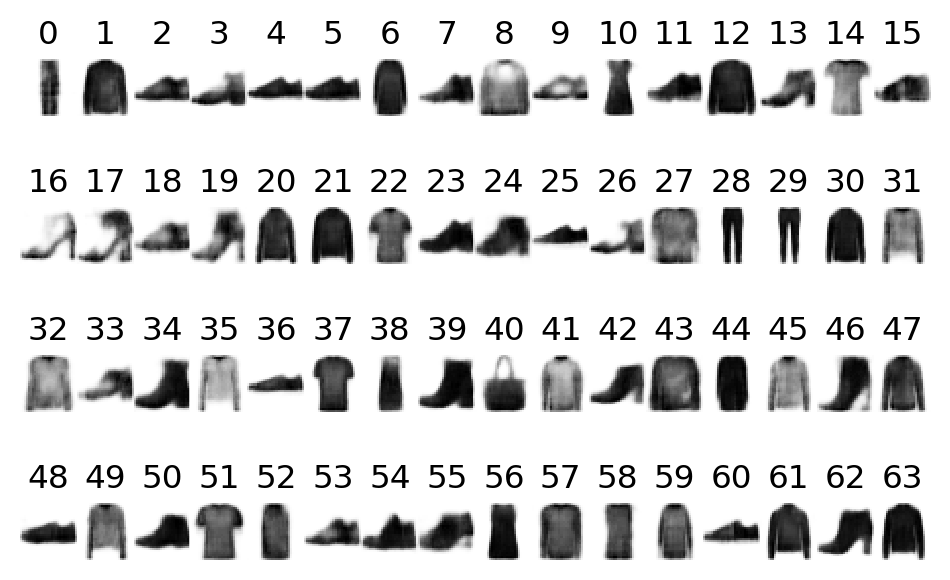

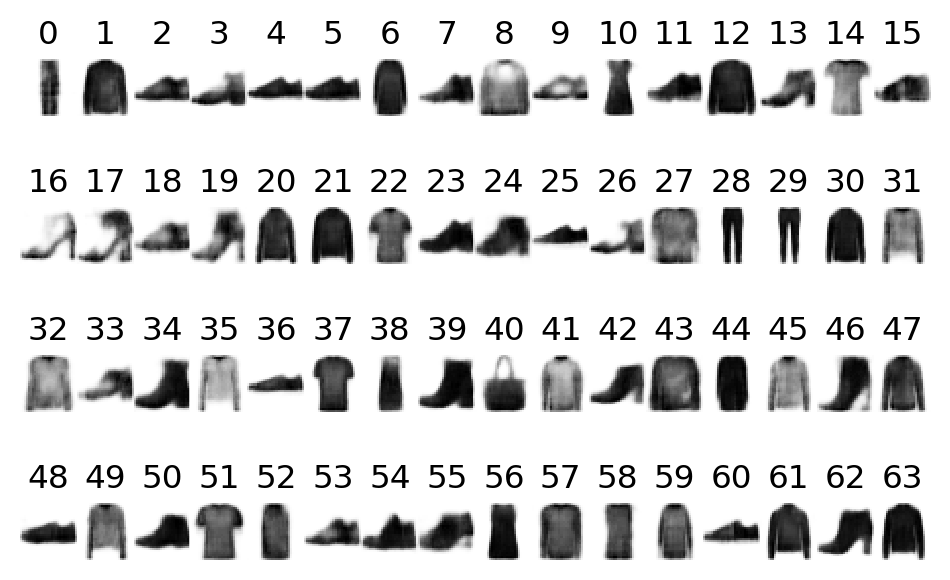

In [18]:
# visualize generation after training
images, _ = next(iter(test_ds))

xs, _, _ = model(images) # latent vectors

display_images(xs[0:64], rows=4, cols=16, dpi=196, labels=range(images.shape[0]))

# Comparison between Original Images and Reconstructions

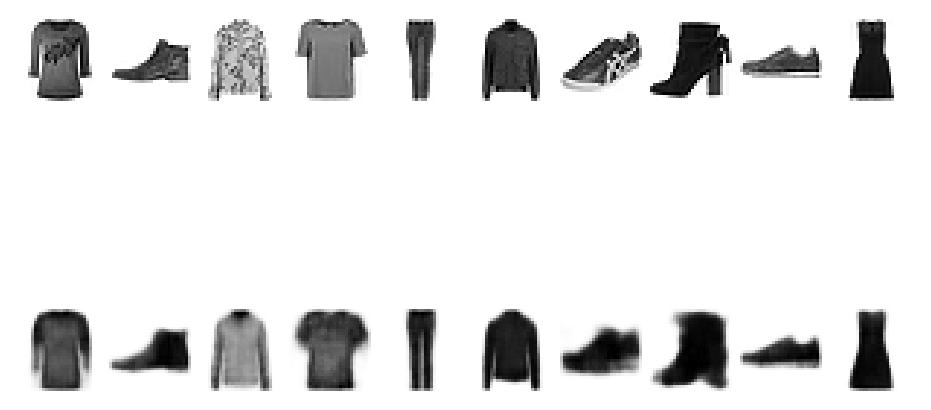

In [19]:
images, _ = next(iter(test_ds))

mu, _, sigma = encoder(images)
zs = sampler((mu, sigma))
xs = decoder(zs)

np.random.seed(8675309)
idxs = np.random.uniform(0, len(images), size=10).astype(int)
imgs = np.concatenate([images.numpy()[idxs], xs.numpy()[idxs]])

fig = display_images(imgs, rows=2, cols=len(idxs), wspace=0.1, dpi=192)
# fig.savefig('recon.svg', format='svg', dpi=500)

<hr>
<h1> Cosine Similarity of Learned Latent Probability Distributions </h1>
<h2> (that is, reduced representation produced by the encoder) </h2>
<h3>I will be using the <i>cosine similarity (ala scipy)</i> to compare the latent vectors.</h3>
<h2>
$
\begin{align}
\text{cosine similarity} \equiv 1 - \frac{\vec{u} \cdot \vec{v}}{\| u \| \| v \|}
\end{align}
$
</h2>

<h3>note: the range of this distance metric is from $0$ (identical) to $2$ (most dissimilar).</h3>


In [20]:
import scipy.spatial.distance

## Illustration of Cosine Similarity Distance Metric 

In [21]:
# Examples for cosine similarity distance metric

# identical vectors
u = np.random.rand(100)
v = u

scipy.spatial.distance.cosine(u, v)

0.0

In [22]:
# orthogonal vectors
u = np.random.rand(100)
v = np.random.rand(100)

# apply Gram-Schmidt to make v orthogonal to u
v -= v.dot(u) * u / np.linalg.norm(u)**2

scipy.spatial.distance.cosine(u, v)

0.9999999999999998

In [23]:
# opposite vectors
u = np.random.rand(100)
v = -u

scipy.spatial.distance.cosine(u, v)

2.0

## Most Similar Exemplars (based on cosine similarity)

In [24]:
TOPS = 0
TROUSERS = 1
PULLOVER = 2
DRESS = 3
COAT = 4
SANDALS = 5
SHIRTS = 6
SNEAKERS = 7
BAGS = 8
ANKLE_BOOTS = 9

In [25]:
n_classes = 10
n_samples_per_class = 25

In [26]:
# randomly draw images from each class in Fashion MNIST
# np.random.seed(8675309)
# imgs = np.concatenate([normalize(xtrain[np.random.choice(np.reshape(np.argwhere(ytrain==mnist_class), -1), n_samples_per_class, replace=False)])[0] 
#                        for mnist_class in range(n_classes)], axis=0)
imgs = np.concatenate([normalize(xtest[np.random.choice(np.reshape(np.argwhere(ytest==mnist_class), -1), n_samples_per_class, replace=False)])[0] 
                       for mnist_class in range(n_classes)], axis=0)

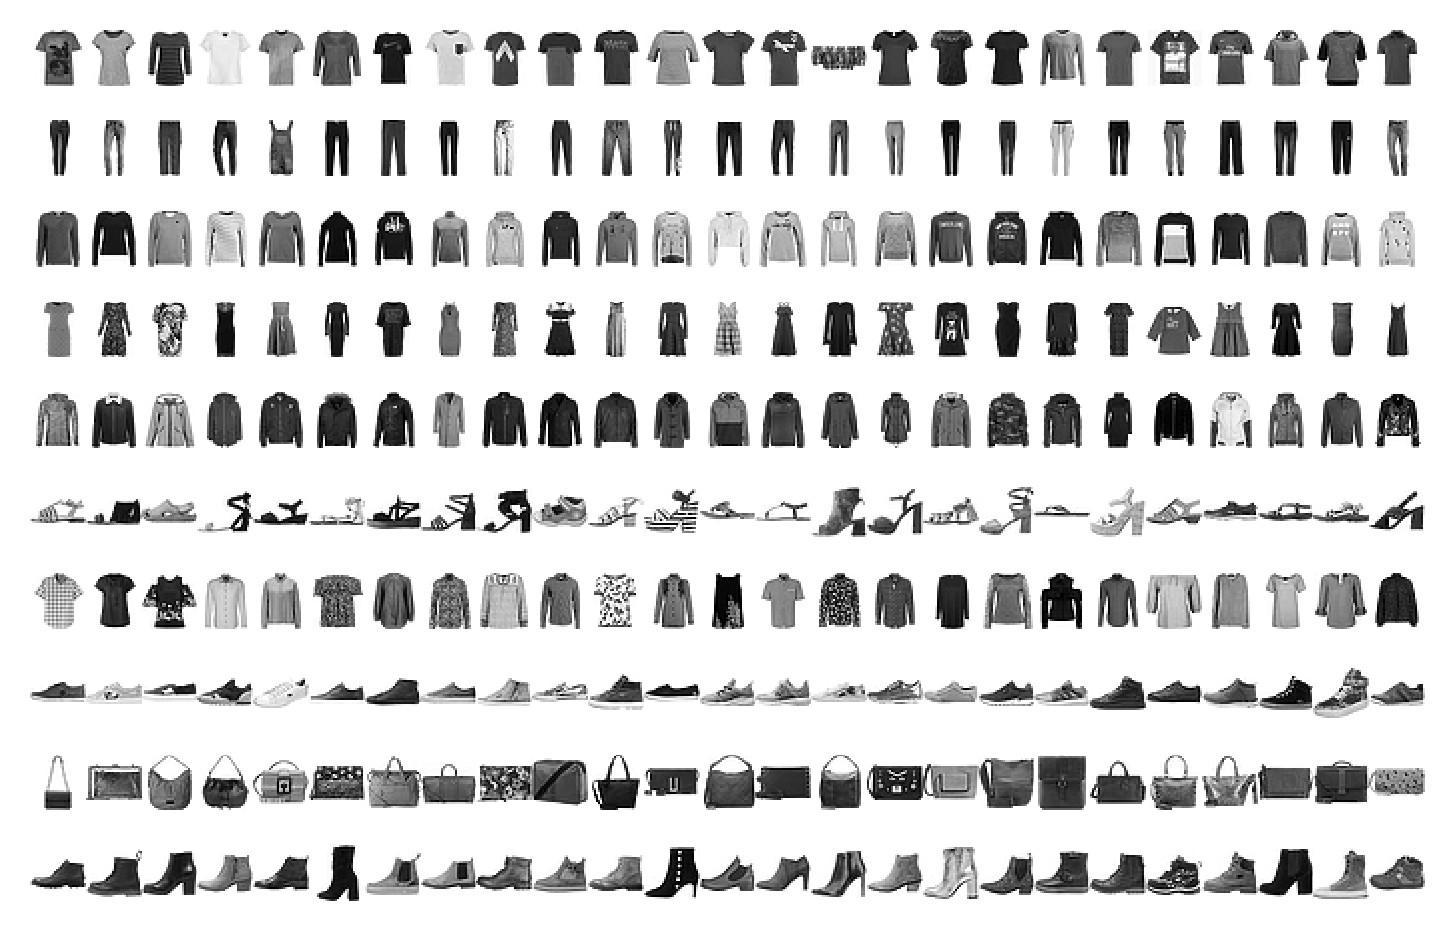

In [27]:
fig = display_images(imgs, rows=10, cols=25, dpi=300)

In [28]:
mu, _, sigma = encoder(imgs)
zs = sampler((mu, sigma))
xs = decoder(zs)

## Calculate a cosine similarity-based distance matrix (this can take a while...)

In [29]:
dist_matrix = np.zeros((len(imgs), len(imgs)))

for query_idx in range(len(imgs)):    
    for i, other in enumerate(mu):
    
        # scipys cosine simularity is from 0 (most similar) to 2 (least similar).
        # transforming it so that 1.0 is most similar and 0.0 is least similar
        dist_matrix[query_idx][i] = (2.0 - scipy.spatial.distance.cosine(mu[query_idx], other)) / 2.0

In [30]:
trans_matrix = np.round(dist_matrix, decimals=2)

In [31]:
# Passing the cosine similarity through a sigmoidal activation function
trans_matrix = 1.0 / (1.0 + np.exp(-20.0*trans_matrix+15.0))

## Create a heatmap showing cosine sim. based "current activations"

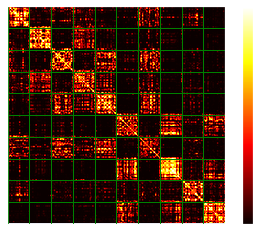

In [222]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

fig = plt.figure()
ax = fig.gca()
im = ax.imshow(trans_matrix, cmap='hot', interpolation='bessel')
ax.set_xticks(np.arange(0,len(imgs)+1,int((len(imgs))/10)))
ax.set_yticks(np.arange(0,len(imgs)+1,int((len(imgs))/10)))

ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='green', linestyle='-', linewidth=1.0)

cb = plt.colorbar(im)
cb.set_ticks([])
    
plt.show()
fig.savefig('curr_act_heatmap.svg', format='svg', dpi=300)

## Find the Most (or Least) Similar Images for a Given Input

In [34]:
def get_n_similar(images, index, dist_matrix, n, reversed=False):
    
    # ranks images by distance from reference image (descending order)
    ranked_indices_with_dist = np.array(sorted(np.array(list(zip(range(len(images)), dist_matrix[index]))), key=lambda x: x[1], reverse=not reversed))
    
    return ranked_indices_with_dist[0:n,:]

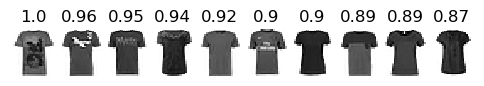

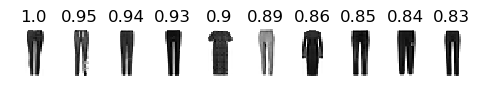

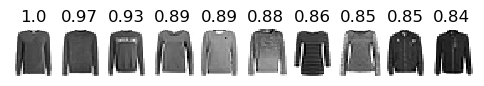

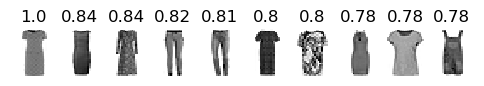

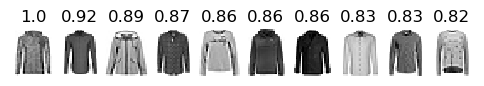

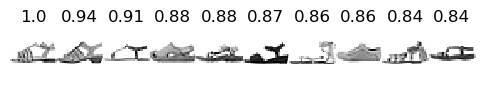

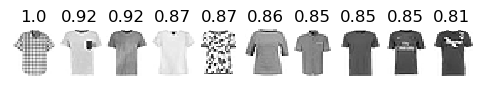

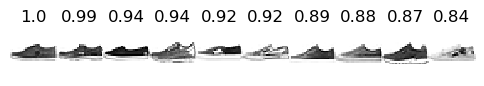

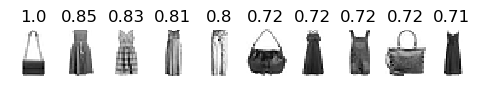

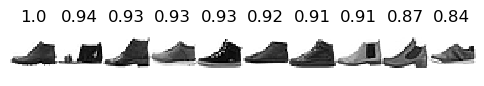

In [35]:
n = 10
ref_ndxs = range(0,n_samples_per_class*n_classes, n_samples_per_class)

curr_class = 0
for ndx in ref_ndxs:
    sims = get_n_similar(imgs, ndx, dist_matrix, n)
    
    indices = sims[:,0].astype(int)
    dists = list(map(str, np.round(sims[:,1], decimals=2)))
    
    fig = display_images(imgs[indices], rows=1, cols=len(indices), labels=dists, dpi=100)
#     fig.savefig('{cls}_distance_from_ref_image.svg'.format(cls=curr_class), format='svg', dpi=100)
    
    curr_class += 1

## K-Nearest Neighbor using latent similarities and activation function

In [206]:
n_exemplars = dist_matrix.shape[0]

conf_matrix = np.zeros(shape=(n_classes, n_classes))
k = 7

for ndx in range(n_exemplars):
    
    # k most similar (removing "best match", which will be a self-reference)
    sims = get_n_similar(imgs, ndx, dist_matrix, k + 1)[1:]
    exemplar_classes = sims[:,0].astype(int) // n_samples_per_class
    
    predicted_class = np.argmax(np.bincount(exemplar_classes))
    actual_class = ndx // n_samples_per_class 
           
    conf_matrix[actual_class,predicted_class] += 1
        
print('overall accuracy: ', sum(np.diag(conf_matrix))/n_exemplars)

overall accuracy:  0.72


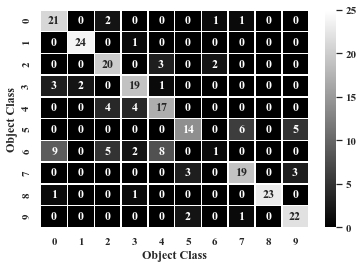

In [197]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

fig = plt.figure()

# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

ax = sns.heatmap(conf_matrix, annot=True, vmax=25, linewidths=.5, cmap="gist_gray", xticklabels=True, yticklabels=True)
ax.set_xlabel("Object Class")
ax.set_ylabel("Object Class")
b, t = ax.get_ylim()
b += 0.5
t -= 0.5
ax.set_ylim(b,t)
plt.show()

fig.savefig('knn_confmatrix.svg', format='svg')

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])